In [428]:
#periodo_filtro="and substring(pro.periodo,0,5) not in('2013','2018')"
periodo_filtro="and substring(pro.periodo,0,5)  in('2016')"

#columnas razonamiento cuantitativo
columnas=['pro.punt_razonamiento_cuantitativo_escala','s11.punt_matematicas']

In [429]:
sql=("SELECT pro.estu_consecutivo AS pro,"+
    "s11.estu_consecutivo AS c11,"+
    columnas[0]+" as pruebaEcaes,"+
    columnas[1]+" as prueba11,"+
    "pro.periodo AS periodo_ecaes,"+
    "s11.periodo AS periodo_11"+
   " FROM proyecto.va_saber_pro pro"+
     " JOIN proyecto.va_cruces c ON pro.estu_consecutivo = c.estu_consecutivo_pro"+
     " JOIN proyecto.va_saber_11 s11 ON s11.estu_consecutivo = c.estu_consecutivo_11"+
  " WHERE pro.departamento_programa = 'NARIÑO'::text "+
  " AND pro.nombre_institucion ~~* 'UNIVERSIDAD DE NARIÑO-PASTO'::text AND pro.programa = 'INGENIERIA DE SISTEMAS'::text "
     +periodo_filtro+
 " ORDER BY pro.periodo;")

In [430]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, event
from urllib.parse import quote_plus

In [431]:
# follows django database settings format, replace with your own settings
DATABASES = {
       'produccion':{
        'NAME': 'proyecto_va',
        'USER': 'postgres',
        'PASSWORD': 'Grias*20',
        'HOST': '10.10.10.117',
        'PORT': 5432,
    }

}

db_produccion=DATABASES['produccion']
prod_engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db_produccion['USER'],
    password = db_produccion['PASSWORD'],
    host = db_produccion['HOST'],
    port = db_produccion['PORT'],
    database = db_produccion['NAME'],
    fast_executemany=True
)

# create sqlalchemy engine
prod= create_engine(prod_engine_string)

In [432]:
df=pd.read_sql_query(sql,prod)
prod.dispose()
df.head()

pro                 c11  pruebaecaes  prueba11 periodo_ecaes  \
0  EK201630175661  SABER1120082330292    48.666667     52.06         20163   
1  EK201630169014  SABER1120081031628    60.000000     50.18         20163   
2  EK201630180945  SABER1120081115609    46.666667     52.61         20163   
3  EK201630175690  SABER1120082117994    49.333333     45.01         20163   
4  EK201630175427  SABER1120082308557    58.666667     52.15         20163   

  periodo_11  
0      20082  
1      20081  
2      20081  
3      20082  
4      20082

In [433]:
#Formula zscore
def z_score(datos):
    z=(datos-datos.mean())/datos.std()
    return z

In [434]:
#Calcular el rendimiento por inidividuo
df['pruebaecaes_rend']=df['pruebaecaes']/df['pruebaecaes'].max()
df['prueba11_rend']=df['prueba11']/df['prueba11'].max()

In [435]:
#aplicar transformación zscore
df['pruebaecaes_norm']=z_score(df['pruebaecaes_rend'])
df['prueba11_norm']=z_score(df['prueba11_rend'])

In [436]:
df.describe()

pruebaecaes   prueba11  pruebaecaes_rend  prueba11_rend  \
count    38.000000  38.000000         38.000000      38.000000   
mean     56.596491  56.472632          0.832301       0.743061   
std       7.621748  10.376169          0.112085       0.136529   
min      38.666667  28.000000          0.568627       0.368421   
25%      50.083333  49.295000          0.736520       0.648618   
50%      58.000000  54.515000          0.852941       0.717303   
75%      62.333333  62.852500          0.916667       0.827007   
max      68.000000  76.000000          1.000000       1.000000   

       pruebaecaes_norm  prueba11_norm  
count      3.800000e+01   3.800000e+01  
mean       1.760288e-16  -1.025495e-15  
std        1.000000e+00   1.000000e+00  
min       -2.352456e+00  -2.744041e+00  
25%       -8.545491e-01  -6.917419e-01  
50%        1.841453e-01  -1.886661e-01  
75%        7.526938e-01   6.148578e-01  
max        1.496180e+00   1.881944e+00

In [437]:
#diferencia
df['va_norm']=df.pruebaecaes-df.prueba11
df['va']=df.pruebaecaes_rend-df.prueba11_rend

In [438]:
df.describe()

pruebaecaes   prueba11  pruebaecaes_rend  prueba11_rend  \
count    38.000000  38.000000         38.000000      38.000000   
mean     56.596491  56.472632          0.832301       0.743061   
std       7.621748  10.376169          0.112085       0.136529   
min      38.666667  28.000000          0.568627       0.368421   
25%      50.083333  49.295000          0.736520       0.648618   
50%      58.000000  54.515000          0.852941       0.717303   
75%      62.333333  62.852500          0.916667       0.827007   
max      68.000000  76.000000          1.000000       1.000000   

       pruebaecaes_norm  prueba11_norm    va_norm         va  
count      3.800000e+01   3.800000e+01  38.000000  38.000000  
mean       1.760288e-16  -1.025495e-15   0.123860   0.089240  
std        1.000000e+00   1.000000e+00   9.842117   0.133690  
min       -2.352456e+00  -2.744041e+00 -23.000000  -0.220588  
25%       -8.545491e-01  -6.917419e-01  -4.361667   0.014721  
50%        1.841453e-01  -1.886661e-01  -1.500000   0.072110  
75%        7.526938e-01   6.148578e-01   5.583333   0.163313  
max        1.496180e+00   1.881944e+00  36.666667   0.582559

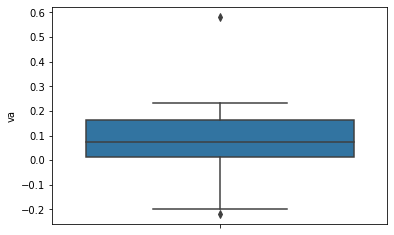

In [439]:
# library & dataset
#!pip install seaborn
import seaborn as sns

# Make boxplot for one group only
sns.boxplot( y=df["va"] )
#sns.plt.show()
df_aux=df.copy()

# Filtrar Ouliers

In [440]:
di=df_aux["va"].quantile(0.75)-df_aux["va"].quantile(0.25)

q3=df_aux["va"].quantile(0.75)
q3=q3+1.5*di

q1=df_aux["va"].quantile(0.25)
q1=q1-(1.5*di)

print(len(df_aux[df_aux.va>=q3]))
print(len(df_aux[df_aux.va<=q1]))

df_aux=df_aux[df_aux.va<q3]
df_aux=df_aux[df_aux.va>q1]

#len(df_aux[df_aux.va<df_aux["va"].quantile(0.25)*3*di])

1
1


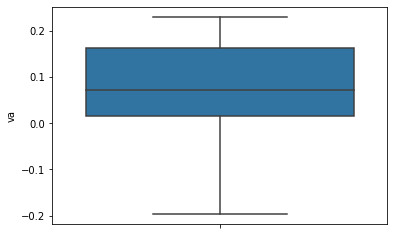

In [441]:
# library & dataset
#!pip install seaborn
import seaborn as sns


 
# Make boxplot for one group only
sns.boxplot(y=df_aux["va"] )
#sns.plt.show()



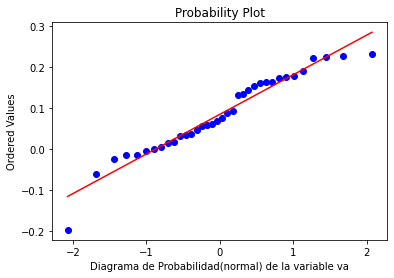

In [442]:
import matplotlib.pyplot as plt
from scipy import stats
def normalidad_variable_numerica(col):
    stats.probplot(df_aux[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()
normalidad_variable_numerica('va')

# D’Agostino and Pearson’s

In [446]:
#H0 es normal
#H1 no es normal

columnas_numericas = df_aux.select_dtypes(['int', 'float64']).columns
for num_col in columnas_numericas:
    _, pval = stats.normaltest(df_aux[num_col])
    #print(pval)
    if(pval < 0.05):
        print("Rechaza h0: Columna {} no sigue una distribución normal".format(num_col), pval)
    else:
        print("No Rechaza ho: Columna {}  sigue una distribución normal".format(num_col),pval)

No Rechaza ho: Columna pruebaecaes  sigue una distribución normal 0.4670735922753865
No Rechaza ho: Columna prueba11  sigue una distribución normal 0.2242753719592489
No Rechaza ho: Columna pruebaecaes_rend  sigue una distribución normal 0.4670735922753849
No Rechaza ho: Columna prueba11_rend  sigue una distribución normal 0.2242753719592517
No Rechaza ho: Columna pruebaecaes_norm  sigue una distribución normal 0.4670735922753867
No Rechaza ho: Columna prueba11_norm  sigue una distribución normal 0.22427537195924996
No Rechaza ho: Columna va_norm  sigue una distribución normal 0.15935573086630503
No Rechaza ho: Columna va  sigue una distribución normal 0.29474816584465663


In [447]:
#Ho es normal
#H1 no es normal


#!pip install plotly
from scipy.stats import normaltest
#import plotly.plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

import numpy as np
import pandas as pd
import scipy

stat, p = normaltest(df_aux.va)

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0) No rechaza H0 Es normal'
else:
    msg = 'Sample does not look Gaussian (reject H0) No es Normal'

print(msg)
p

Sample looks Gaussian (fail to reject H0) No rechaza H0 Es normal


0.29474816584465663

In [449]:
#Ho es normal
#H1 no es normal
#import numpy as np
#from scipy.stats import kstest

#pvalue=kstest(df_aux.va,'norm').pvalue
#if pvalue<0.05:
#    print("Rechaza h0: Columna {} no sigue una distribución normal".format(num_col), pvalue)
#else:
#    print("No Rechaza ho: Columna {}  sigue una distribución normal".format(num_col),pvalue)

# Shapiro-Wilk Test

In [450]:
#Ho Es normal
#H1 No es normal

from scipy.stats import shapiro
stat, p = shapiro(df_aux.va)

# interpret
alpha = 0.05
if p < alpha:
    msg = 'rechaza H0: no es normal'
else:
    msg = 'No rechaza H0: es normal'
    
print(msg)
print("probabilidad:",p)
print("valor stat:",stat)

No rechaza H0: es normal
probabilidad: 0.10567111521959305
valor stat: 0.9501438140869141


# Anderson-Darling Test

In [451]:
#H0: es normal
#H1: no es

from scipy.stats import anderson
import plotly.graph_objs as go

result = anderson(df_aux.va)
stat = round(result.statistic, 4)

p = 0
result_mat = []
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        msg = '(fail to reject H0) Es Normal'
    else:
        msg = '(reject H0) No es Normal'
    result_mat.append([len(df_aux.va), stat, sl, cv, msg])

trace = go.Table(
    header=dict(values=['<b>Sample Size</b>', '<b>Statistic</b>', '<b>Significance Level</b>', '<b>Critical Value</b>', '<b>Comment</b>'],
                line = dict(width=0),
                fill = dict(color='rgba(42,63,95,0.8)'),
                align = 'center',
                font = dict(
                    color = '#ffffff',
                    size = 12
                )),
    cells=dict(values=np.array(result_mat).T,
               line = dict(width=0),
               fill = dict(color=[['#EBF0F8', '#ffffff', '#EBF0F8', '#ffffff', '#EBF0F8']]),
               align = 'center',
               height = 40),
    columnwidth=[0.3, 0.25, 0.3, 0.25, 0.5])
layout = dict(
    height=300,
    margin=dict(
        l=5,
        r=5,
        t=30,
        b=0
    )
)
data = [trace]
andar_table = dict(data=data, layout=layout)

result_mat

[[36, 0.4824, 15.0, 0.528, '(fail to reject H0) Es Normal'],
 [36, 0.4824, 10.0, 0.601, '(fail to reject H0) Es Normal'],
 [36, 0.4824, 5.0, 0.721, '(fail to reject H0) Es Normal'],
 [36, 0.4824, 2.5, 0.841, '(fail to reject H0) Es Normal'],
 [36, 0.4824, 1.0, 1.0, '(fail to reject H0) Es Normal']]

# Test Hipotesis

In [452]:
#muestreo aleotorio 
import math 

def tobs(datos,tam_muestra):
    df_aux_t=datos.sample(n=tam_muestra)
 
    d=df_aux_t['va'].mean()
    n=df_aux_t['va'].count()
    sd=df_aux_t['va'].std()

    tObs=(d-0)/(sd/math.sqrt(n))
    return (tObs,n,d,sd)

resultado=tobs(df_aux,df_aux.va.count())
#resultado=tobs(df_aux,180)
resultado

#HO Md<=0 No aporta 
#H1 Md>0  aporta

(5.271619178224372, 36, 0.0841434468524252, 0.09576956605666692)